In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data
-  CF_DATA.zip: all the images
- classification.csv: folder name, image name, class
- Total datapoints: 627

----------------Dataset-----------
- IDRiD Testing Set  : 103
- IDRiD Training Set  : 413
- drive  : 31
- messidor2  : 80
- Total datapoints:  627


----------------Labels------------
- Label  0 : 	 295
- Label  1 : 	 58
- Label  2 : 	 274
- Total datapoints:  627

## Shapes
- IDRiD Testing Set  : (2848, 4288)
- IDRiD Training Set  : (2848, 4288)
- drive  : (584, 565)
- messidor2  : (1488, 2240)

#Import 

In [ ]:
# %%capture
# !pip install wandb
# !wandb login 2fcff50b0d3105668ec3c4a4c3676a1da141bb7c
# import wandb

In [ ]:
%load_ext tensorboard

SEED = 1
import numpy as np; np.random.seed(SEED)
import torch; torch.manual_seed(SEED);# torch.use_deterministic_algorithms(True)
import random; random.seed(SEED)

import torchvision
from torchvision import transforms as T
import torch.nn as nn
import pandas as pd
from tqdm.auto import tqdm 
from IPython.display import Image 
import os
from skimage import io
import time
from sklearn.model_selection import train_test_split
from collections import Counter
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score
from torch.utils.tensorboard import SummaryWriter
from skimage.transform import resize as io_resize
import cv2
import datetime
from google.colab.patches import cv2_imshow
import albumentations as A
import albumentations.pytorch

#Data Processing 


##Loading data 

In [ ]:
!rm -rf 'sample_data'

In [ ]:
!ls /content/drive/MyDrive/optham_research/AMD-Classification/

CF_DATA_512.zip  CF_DATA.zip  cf_runs		  classificationNew.csv
CF_DATA_PP.zip	 cf_models    classification.csv


In [ ]:
%%%capture
#loading data
!unzip /content/drive/MyDrive/optham_research/AMD-Classification/CF_DATA_512.zip -d /content/

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/optham_research/AMD-Classification/classificationNew.csv')
print(df.shape)

(859, 3)


In [ ]:
df.head()

,dataset,image,label
0,IDRiD Training Set,IDRiD_001,2
1,IDRiD Training Set,IDRiD_002,2
2,IDRiD Training Set,IDRiD_003,2
3,IDRiD Training Set,IDRiD_004,2
4,IDRiD Training Set,IDRiD_005,0


In [ ]:
df.tail()

,dataset,image,label
854,augData Label1,560ver3,1
855,augData Label1,79ver3,1
856,augData Label1,332ver2,1
857,augData Label1,261ver1,1
858,augData Label1,560ver2,1


##Data Cleaning and Analysis

In [ ]:
data_names = ['IDRiD Testing Set', 'IDRiD Training Set', 'drive', 'messidor2', 'augData Label1']

In [ ]:
# changed all file extensions to png
for i in range(len(data_names)): 
  for img in os.listdir(f"CF_DATA/{data_names[i]}"):
    os.rename(f"CF_DATA/{data_names[i]}/{img}", f"CF_DATA/{data_names[i]}/{os.path.splitext(img)[0] + '.png'}")
print("Done")

Done


In [ ]:
# # sanity check for file extensions
# for i in range(len(data_names)): 
#   for img in os.listdir(f"CF_DATA/{data_names[i]}"):
#     if(img.split(".")[1]!="png"):
#       print(img)
# print("Sanity check done")

In [ ]:
#dataset count
dsum=0
print("----------------Dataset-----------")
for i in range(len(data_names)):
  print(data_names[i]," :",len(os.listdir(f"CF_DATA/{data_names[i]}")))
  #print("Folder: \t",len(os.listdir(f"CF_DATA/{data_names[i]}")))
  dsum=dsum+df.loc[df['dataset']== data_names[i]].shape[0]
  #print("Csv file: \t", df.loc[df['dataset']== data_names[i]].shape[0] )
print("Total datapoints: ",dsum)
print("\n")

lsum=0
print("----------------Labels------------")
for i in range(0,3):
  print("Label ",i,": \t", df.loc[df['label']== i].shape[0])
  lsum=lsum+df.loc[df['label']== i].shape[0]
print("Total datapoints: ",lsum)
print("\n")

----------------Dataset-----------
IDRiD Testing Set  : 103
IDRiD Training Set  : 413
drive  : 31
messidor2  : 80
augData Label1  : 232
Total datapoints:  859


----------------Labels------------
Label  0 : 	 295
Label  1 : 	 290
Label  2 : 	 274
Total datapoints:  859




In [ ]:
# #loading images sanity check

# img1=cv2.imread('/content/CF_DATA/IDRiD Testing Set/IDRiD_003.png')
# print(img1.shape) #ooo mah gwaadd it huge
# # cv2_imshow(img1)
# img2=cv2.imread('/content/CF_DATA/IDRiD Training Set/IDRiD_022.png')
# print(img2.shape) #ooo mah gwaadd it huge
# # cv2_imshow(img2)
# img3=cv2.imread('/content/CF_DATA/drive/22image.png')
# print(img3.shape) #ooo mah gwaadd it huge
# # cv2_imshow(img3)
# img4=cv2.imread('/content/CF_DATA/messidor2/20060522_45111_0100_PP.png')
# print(img4.shape) #ooo mah gwaadd it huge
# # cv2_imshow(img4)

In [ ]:
# shapes_1 = []
# file_n = 'IDRiD Testing Set'
# for image in os.listdir(f'/content/CF_DATA/{file_n}/'):
#   shapes_1.append(cv2.imread(os.path.join(f'/content/CF_DATA/{file_n}/', image)).shape)
# print(len(shapes_1))

# shapes_2 = []
# file_n = 'IDRiD Training Set'
# for image in os.listdir(f'/content/CF_DATA/{file_n}/'):
#   shapes_2.append(cv2.imread(os.path.join(f'/content/CF_DATA/{file_n}/', image)).shape)
# print(len(shapes_2))

# shapes_3 = []
# file_n = 'drive'
# for image in os.listdir(f'/content/CF_DATA/{file_n}/'):
#   shapes_3.append(cv2.imread(os.path.join(f'/content/CF_DATA/{file_n}/', image)).shape)
# print(len(shapes_3))

# shapes_4 = []
# file_n = 'messidor2'
# for image in os.listdir(f'/content/CF_DATA/{file_n}/'):
#   shapes_4.append(cv2.imread(os.path.join(f'/content/CF_DATA/{file_n}/', image)).shape)
# print(len(shapes_4))

In [ ]:
# x_1 = [sh[0] for sh in shapes_1]
# y_1 = [sh[1] for sh in shapes_1]

# print(min(x_1), max(x_1))
# print(min(y_1), max(y_1))

In [ ]:
import matplotlib.pyplot as plt
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()


In [ ]:
#loading images sanity check 2nd edition
IMG_SIZE = 100
imgs = [[], [], []]
lbls = [[], [], []]
for ind in tqdm(range(df.shape[0])):
  row=df.iloc[ind]
  path=f"CF_DATA/{row['dataset']}/{row['image']}.png"
  # print(path)
  # print(row['label'])
  img=cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
  # cv2_imshow(img)
  imgs[row['label']].append(img)
  lbls[row['label']].append(f"{row['label']}--{path.replace('CF_DATA/', '')}")
  # if ind == 3:
  #   break


  0%|          | 0/859 [00:00<?, ?it/s]

In [ ]:
# #loading images sanity check 2nd edition
# IMG_SIZE = 100
# imgs = [[], [], []]
# lbls = [[], [], []]
# for ind in tqdm(range(df.shape[0])):
#   row=df.iloc[ind]
#   path=f"CF_DATA/{row['dataset']}/{row['image']}.png"
#   # print(path)
#   # print(row['label'])
#   img=cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
#   b,g,r = cv2.split(img)
#   for i in range(0,g.shape[0]):
#     for j in range(0,g.shape[1]):
#       if g[i,j]>40 and g[i,j] <190:
#         g[i,j]= int((g[i,j]-40)*255/150)
#   # cv2_imshow(img)
#   imgs[row['label']].append(g)
#   lbls[row['label']].append(f"{row['label']}--{path.replace('CF_DATA/', '')}")

```
----------------Dataset-----------
IDRiD Testing Set  : 103
IDRiD Training Set  : 413
drive  : 31
messidor2  : 80
augData Label1  : 232
Total datapoints:  859


----------------Labels------------
Label  0 : 	 295
Label  1 : 	 290
Label  2 : 	 274
Total datapoints:  859
```

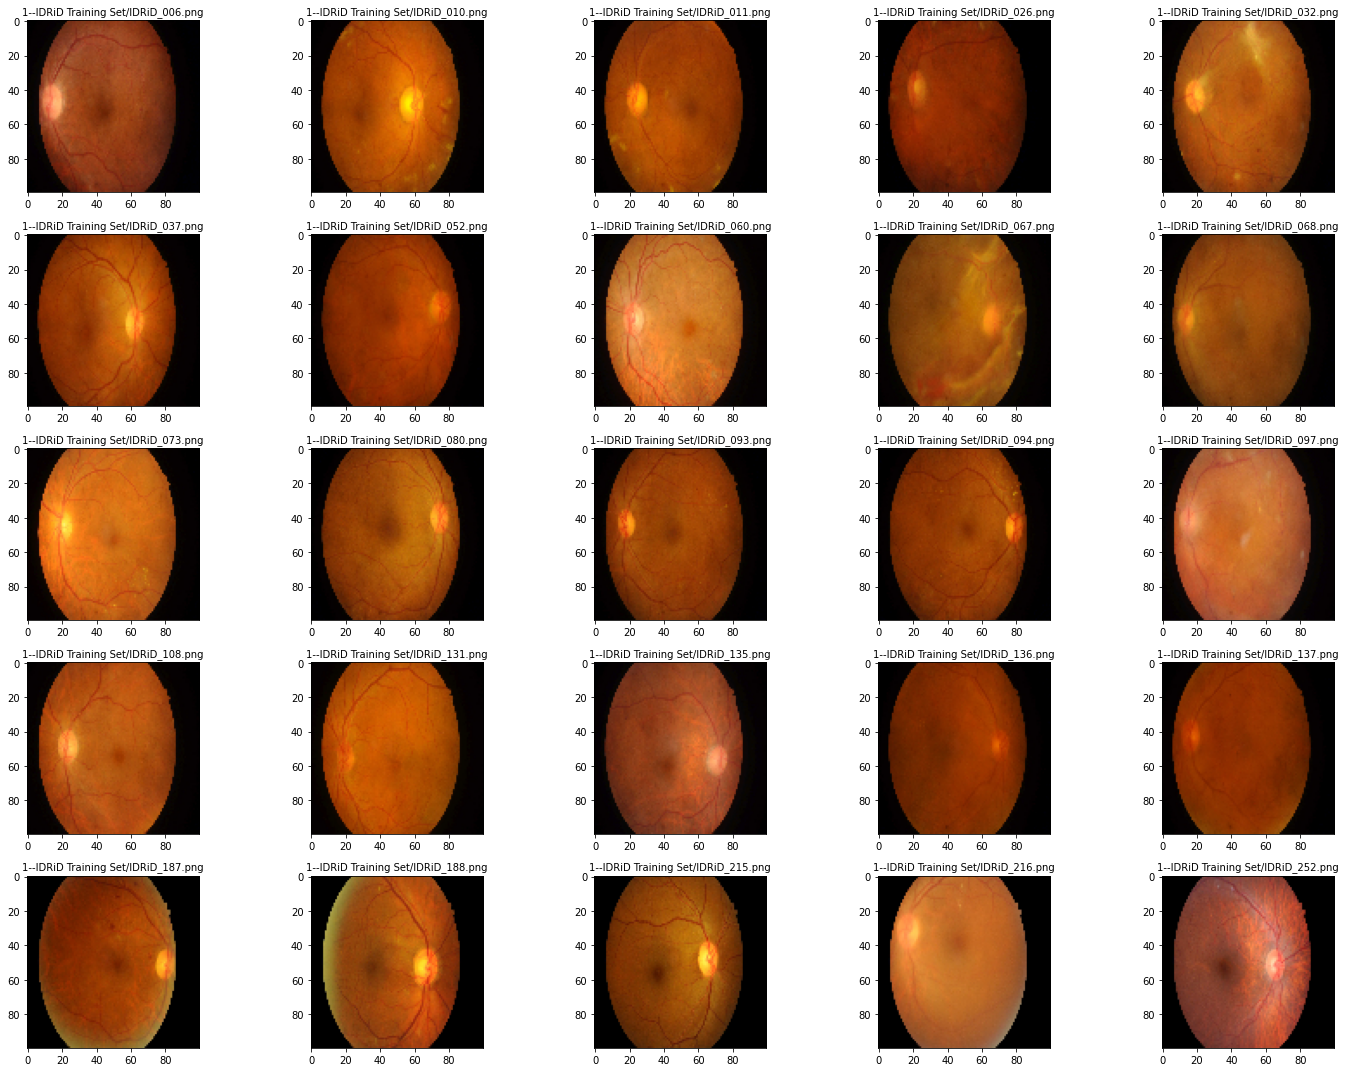

In [ ]:
label = 1
num_rows = 5
num_cols = 5
show_image_list(list_images=imgs[label][:num_rows*num_cols], 
                list_titles=lbls[label][:num_rows*num_cols],
                num_cols=num_cols,
                figsize=(num_cols*4, num_rows*3),
                grid=False,
                title_fontsize=10)

##Configuration

In [ ]:
TENSORBOARD_DIR = "/content/drive/MyDrive/optham_research/AMD-Classification/cf_runs"
MODELS_DIR = "/content/drive/MyDrive/optham_research/AMD-Classification/cf_models"
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

#DataLoader

In [ ]:
class T1Dataset(torch.utils.data.Dataset):
  """
  This is to use with array of files and array of labels as an input
  """
  def __init__(self, X, y, transform=None):
    self.X = X
    self.y = y
    assert len(self.X) == len(self.y)
    self.transform = transform
  
  def __len__(self):
    return len(self.y)

  # def preprocess(self, img, IMG_SIZE=512):
  #   img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  #   b,g,r = cv2.split(img)
  #   for i in range(0,g.shape[0]):
  #     for j in range(0,g.shape[1]):
  #       if g[i,j]>40 and g[i,j] <190:
  #         g[i,j]= int((g[i,j]-40)*255/150)
  #   return g
  
  def __getitem__(self, idx):
    image = cv2.imread(self.X[idx])
    #fimage = self.preprocess(image)
    if self.transform is not None:
      image = self.transform(image)
    return (image*255, self.y[idx])

In [ ]:
#generating X and Y
X=[]
Y=[]

for ind in range(df.shape[0]):
  row=df.iloc[ind]
  path=f"CF_DATA/{row['dataset']}/{row['image']}.png"
  X.append(path)
  Y.append(row['label'])

print(X)
print(Y)
print(len(X), len(Y))

['CF_DATA/IDRiD Training Set/IDRiD_001.png', 'CF_DATA/IDRiD Training Set/IDRiD_002.png', 'CF_DATA/IDRiD Training Set/IDRiD_003.png', 'CF_DATA/IDRiD Training Set/IDRiD_004.png', 'CF_DATA/IDRiD Training Set/IDRiD_005.png', 'CF_DATA/IDRiD Training Set/IDRiD_006.png', 'CF_DATA/IDRiD Training Set/IDRiD_007.png', 'CF_DATA/IDRiD Training Set/IDRiD_008.png', 'CF_DATA/IDRiD Training Set/IDRiD_009.png', 'CF_DATA/IDRiD Training Set/IDRiD_010.png', 'CF_DATA/IDRiD Training Set/IDRiD_011.png', 'CF_DATA/IDRiD Training Set/IDRiD_012.png', 'CF_DATA/IDRiD Training Set/IDRiD_013.png', 'CF_DATA/IDRiD Training Set/IDRiD_014.png', 'CF_DATA/IDRiD Training Set/IDRiD_015.png', 'CF_DATA/IDRiD Training Set/IDRiD_016.png', 'CF_DATA/IDRiD Training Set/IDRiD_017.png', 'CF_DATA/IDRiD Training Set/IDRiD_018.png', 'CF_DATA/IDRiD Training Set/IDRiD_019.png', 'CF_DATA/IDRiD Training Set/IDRiD_020.png', 'CF_DATA/IDRiD Training Set/IDRiD_021.png', 'CF_DATA/IDRiD Training Set/IDRiD_022.png', 'CF_DATA/IDRiD Training Set/IDR

In [ ]:
#stop

In [ ]:
# !rm -rf '/content/CF_DATA/augData'

In [ ]:
# os.mkdir("/content/CF_DATA/augData")
# AUG_PATH = "/content/CF_DATA/augData"
#AUG_SAVE_PATH = "/content/drive/MyDrive/augData"

In [ ]:
#OFFLINE AUGMENTATION

# augment = A.Compose([A.Resize(512,512)])

# augment1 = A.Compose([A.HorizontalFlip(p=1.0)])
# augment2 = A.Compose([A.VerticalFlip(p=1.0)])
# augment3 = A.Compose([A.Rotate(p=1.0)])
# augment4 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3,contrast_limit=0.3, p=1.0)])
                      
#                       # A.Flip(p=1.0),
#                       # A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.5),
#                       # A.Rotate(p=0.5)
#                       # #A.Affine(scale=(0.75,1.25), translate_percent=0.2, p=0.3)
#                       # ])

# # augX = []
# # augY = []

# for i in range(0,len(X)):
#   if(Y[i]==1):
#     img = cv2.imread(os.path.join('/content',X[i]))
#     #cv2_imshow(img)
#     transformed = augment(image=img)
#     t_image = transformed["image"]

#     aug1 = augment1(image=t_image)
#     aug2 = augment2(image=t_image)
#     aug3 = augment3(image=t_image)
#     aug4 = augment4(image=t_image)

#     f1_img = aug1["image"]
#     cv2.imwrite(os.path.join(AUG_SAVE_PATH,str(i)+"ver1.png"),f1_img)
#     f2_img = aug2["image"]
#     cv2.imwrite(os.path.join(AUG_SAVE_PATH,str(i)+"ver2.png"),f2_img)
#     f3_img = aug3["image"]
#     cv2.imwrite(os.path.join(AUG_SAVE_PATH,str(i)+"ver3.png"),f3_img)
#     f4_img = aug4["image"]
#     cv2.imwrite(os.path.join(AUG_SAVE_PATH,str(i)+"ver4.png"),f4_img)


#   #cv2_imshow(f_image)
#   #cv2.imwrite(os.path.join(AUG_PATH,str(i)+".png"),f_image)
#   # augX.append(os.path.join(AUG_PATH,str(i)+".png"))
#   # augY.append(Y[i])

In [ ]:
# print(augX)
# print(augY)
# X = X + augX
# Y = Y + augY
# print(len(X))
# print(len(Y))

# Train Function & Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, criterion, optimizer, num_epochs, unique_name, scheduler=None): #, wandb=None):
  # writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_DIR, f'{unique_name}'))
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  img, lbl = next(iter(dataloaders['train']))
  for epoch in range(num_epochs):
    metric_dict = {}
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0
      running_f1 = 0
      epoch_preds = []
      epoch_lbls = []

      for img, lbl in tqdm(dataloaders[phase], desc=f"Epoch {epoch+1}/{num_epochs}", disable=(phase=='valid')):
        img = img.to(device)
        lbl = lbl.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          output = model(img)
          _, preds = torch.max(output, 1)
          loss = criterion(output, lbl)
          epoch_preds.extend(preds.detach().cpu())
          epoch_lbls.extend(lbl.detach().cpu())
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * img.size(0)
      

      if scheduler is not None and phase == 'train':
        scheduler.step()
      epoch_loss = running_loss / dataset_size[phase]
      epoch_acc = accuracy_score(epoch_lbls, epoch_preds)
      epoch_f1 = f1_score(epoch_lbls, epoch_preds, average='macro')
      # writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
      # writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
      # writer.add_scalar(f'F1/{phase}', epoch_f1, epoch)
      
      metric_dict[f"{phase}_loss"] = epoch_loss
      metric_dict[f"{phase}_acc"] = epoch_acc
      metric_dict[f"{phase}_f1"] = epoch_f1
      # if phase == "valid":
      #   wandb.log(metric_dict)

      print(f'Epoch {epoch}, {phase} Loss: {epoch_loss:.4f}, Acc:{epoch_acc:.4f}, F1: {epoch_f1:.4f}')
      print(confusion_matrix(epoch_lbls, epoch_preds))
      print(classification_report(epoch_lbls, epoch_preds))
      

      if phase == 'valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if (epoch+1)%10==0:
        torch.save(best_model_wts,os.path.join(MODELS_DIR,f'{unique_name}-{epoch+1}.pt'))
        best_model_wts = copy.deepcopy(model.state_dict())
  
  time_elapsed = time.time() - since
  # writer.close()
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
IN_CHANNELS = 3

In [ ]:
class div_2_conv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
  def forward(self, x):
    return self.layers(x)
class same_conv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
    )
  def forward(self, x):
    return self.layers(x)
class customModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        div_2_conv(in_ch=IN_CHANNELS, out_ch=16),
        div_2_conv(in_ch=16, out_ch=16),
        div_2_conv(in_ch=16, out_ch=32),
        div_2_conv(in_ch=32, out_ch=32),
        div_2_conv(in_ch=32, out_ch=64),
        div_2_conv(in_ch=64, out_ch=64),
        same_conv(in_ch=64, out_ch=32),
        same_conv(in_ch=32, out_ch=16),
        same_conv(in_ch=16, out_ch=8),
        nn.Flatten(),
    )
    self.dim = 512
    self.fcn = nn.Linear(self.dim, 3)
  def forward(self, x):
    out = self.layers(x)
    out = self.fcn(out)
    return out

In [ ]:
# model = customModel()
# count_parameters(model)
# a = torch.randn(8, 3, 512, 512)
# out = model(a)
# # model(a)
# out.shape

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# Train Loop

In [ ]:
!ls /content/drive/MyDrive/optham_research/AMD-Classification/

CF_DATA_512.zip  CF_DATA.zip  cf_runs		  classificationNew.csv
CF_DATA_PP.zip	 cf_models    classification.csv


In [ ]:
falalalalalalaaaaaa

NameError: ignored

In [ ]:
# Train-Valid split:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size=0.8, stratify=Y)
#X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size=0.9, stratify=Y)
# X_train = X_valid
# y_train = y_valid

In [ ]:
# Generating sampler to handle the class imbalance:
unique_labels, counts = np.unique(y_train, return_counts=True)
class_weights = [1/c for c in counts]
sample_weights = [0] * len(y_train)
for idx, lbl in enumerate(y_train):
  sample_weights[idx] = class_weights[lbl]
sampler_train = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
print(unique_labels)
print(counts)
print(class_weights)

[0 1 2]
[236 232 219]
[0.00423728813559322, 0.004310344827586207, 0.0045662100456621]


In [ ]:
IMG_DIM = 512
CLASSES = {'Normal':0, 'Mild':1, 'Severe':2}

In [ ]:
# Transforms for data augmentation:
transforms = { 
'train' : T.Compose([
                      T.ToTensor(),
                      T.RandomHorizontalFlip(),
                      T.RandomVerticalFlip()
                      #T.Resize((IMG_DIM,IMG_DIM)),
                      # T.RandomResizedCrop(3000),
                      
        ]),
'valid' : T.Compose([
                    T.ToTensor()
                    #T.CenterCrop(3000),
                    #T.Resize((IMG_DIM,IMG_DIM)),
                    
        ])
}

# Dataset & Dataloaders:

train_set = T1Dataset(X_train, y_train, transform=transforms['train'])
valid_set = T1Dataset(X_valid, y_valid, transform=transforms['valid'])
dataset_size = {
    'train':len(train_set),
    'valid':len(valid_set)
}

In [ ]:
# image, label = next(iter(dataloaders['train']))
# img = image[0].permute(1, 2, 0).cpu().numpy()
# print(label[0])
# cv2_imshow(cv2.resize(img, (100, 100))) 

In [ ]:
print(dataset_size)

{'train': 687, 'valid': 172}


In [ ]:
### CUSTOM MODEL ###
# model = customModel()

### MOBILENET ###
# import torchvision.models as models
# model = models.mobilenet_v3_small(pretrained=True)
# model.classifier[-1] = nn.Linear(1024, len(CLASSES))

### ALEXNET ###
# import torchvision.models as models
# model = models.alexnet(pretrained=True)
# model.classifier[-1] = nn.Linear(4096, len(CLASSES))

## RESNET ###
# import torchvision.models as models
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(in_features=512, out_features=len(CLASSES))

### EFFNET ###
# !pip3 install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=len(CLASSES))

import torchvision.models as models
model = models.efficientnet_b3(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=1536, out_features=len(CLASSES))

# for param in model.parameters():
#   param.requires_grad = False
# model.fc.weight.requires_grad = True
# model.fc.bias.requires_grad = True


model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [ ]:
# count_parameters(model) # res18: 11M, alexnet: 57M, mobilenet_v3_small: 1.5M, custom_model: 98k

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
LR = 5e-4 # 5e-4 lr --> 1e-4 loss, 1e-4 --> 4e-4, 1e-3 --> 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

batch_size = 8

dataloaders = {
    # 'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=sampler_train),
    #'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size,),
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
    #'valid': torch.utils.data.DataLoader(valid_set, batch_size=batch_size,)
}

print(len(dataloaders['train'].dataset), len(dataloaders['valid'].dataset))

epochs = 30
# unique_name = f"effnetb3-2-{batch_size}-adam-{LR}-{IMG_DIM}-{len(CLASSES)}_cls"
# unique_name = f"final-augl1-effnetb3-{batch_size}-adam-{LR}-{IMG_DIM}-{len(CLASSES)}"
unique_name = "torchcam"

687 172


In [ ]:
# # %%capture
# wandb.init(project="ophthalmology", 
#            entity="sahilkhose", 
#            config={
#                       "unique_name": unique_name,
#                       "batch_size": batch_size,
#                       "LR": LR,
#                       "IMG_DIM": IMG_DIM,
#                 },
# #            name=f"{}{}{}{}"
#           )

In [ ]:
best_model = train(model, criterion, optimizer, epochs, unique_name) #, wandb=wandb) # 2hours for 40 epochs, 100% overfit on train in the end

Epoch 1/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 0, train Loss: 0.7671, Acc:0.6696, F1: 0.6691
[[177  44  15]
 [ 54 142  36]
 [ 34  44 141]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       236
           1       0.62      0.61      0.61       232
           2       0.73      0.64      0.69       219

    accuracy                           0.67       687
   macro avg       0.67      0.67      0.67       687
weighted avg       0.67      0.67      0.67       687

Epoch 0, valid Loss: 0.7272, Acc:0.7151, F1: 0.7136
[[52  7  0]
 [19 34  5]
 [ 9  9 37]]
              precision    recall  f1-score   support

           0       0.65      0.88      0.75        59
           1       0.68      0.59      0.63        58
           2       0.88      0.67      0.76        55

    accuracy                           0.72       172
   macro avg       0.74      0.71      0.71       172
weighted avg       0.73      0.72      0.71       172



Epoch 2/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 1, train Loss: 0.5362, Acc:0.7933, F1: 0.7934
[[200  28   8]
 [ 39 169  24]
 [ 16  27 176]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       236
           1       0.75      0.73      0.74       232
           2       0.85      0.80      0.82       219

    accuracy                           0.79       687
   macro avg       0.79      0.79      0.79       687
weighted avg       0.79      0.79      0.79       687

Epoch 1, valid Loss: 0.5808, Acc:0.7733, F1: 0.7716
[[52  6  1]
 [10 44  4]
 [ 8 10 37]]
              precision    recall  f1-score   support

           0       0.74      0.88      0.81        59
           1       0.73      0.76      0.75        58
           2       0.88      0.67      0.76        55

    accuracy                           0.77       172
   macro avg       0.79      0.77      0.77       172
weighted avg       0.78      0.77      0.77       172



Epoch 3/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 2, train Loss: 0.4098, Acc:0.8384, F1: 0.8388
[[204  25   7]
 [ 24 190  18]
 [ 15  22 182]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       236
           1       0.80      0.82      0.81       232
           2       0.88      0.83      0.85       219

    accuracy                           0.84       687
   macro avg       0.84      0.84      0.84       687
weighted avg       0.84      0.84      0.84       687

Epoch 2, valid Loss: 0.6894, Acc:0.7907, F1: 0.7928
[[46 11  2]
 [ 2 50  6]
 [ 2 13 40]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        59
           1       0.68      0.86      0.76        58
           2       0.83      0.73      0.78        55

    accuracy                           0.79       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.81      0.79      0.79       172



Epoch 4/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 3, train Loss: 0.3514, Acc:0.8719, F1: 0.8717
[[209  17  10]
 [ 13 204  15]
 [ 14  19 186]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       236
           1       0.85      0.88      0.86       232
           2       0.88      0.85      0.87       219

    accuracy                           0.87       687
   macro avg       0.87      0.87      0.87       687
weighted avg       0.87      0.87      0.87       687

Epoch 3, valid Loss: 0.4517, Acc:0.8081, F1: 0.8061
[[50  9  0]
 [ 2 52  4]
 [ 7 11 37]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        59
           1       0.72      0.90      0.80        58
           2       0.90      0.67      0.77        55

    accuracy                           0.81       172
   macro avg       0.82      0.81      0.81       172
weighted avg       0.82      0.81      0.81       172



Epoch 5/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 4, train Loss: 0.2409, Acc:0.9127, F1: 0.9125
[[221   9   6]
 [ 11 209  12]
 [ 12  10 197]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       236
           1       0.92      0.90      0.91       232
           2       0.92      0.90      0.91       219

    accuracy                           0.91       687
   macro avg       0.91      0.91      0.91       687
weighted avg       0.91      0.91      0.91       687

Epoch 4, valid Loss: 0.3906, Acc:0.8605, F1: 0.8573
[[53  1  5]
 [ 0 54  4]
 [ 6  8 41]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        59
           1       0.86      0.93      0.89        58
           2       0.82      0.75      0.78        55

    accuracy                           0.86       172
   macro avg       0.86      0.86      0.86       172
weighted avg       0.86      0.86      0.86       172



Epoch 6/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 5, train Loss: 0.1975, Acc:0.9374, F1: 0.9376
[[223   8   5]
 [ 13 213   6]
 [  5   6 208]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       236
           1       0.94      0.92      0.93       232
           2       0.95      0.95      0.95       219

    accuracy                           0.94       687
   macro avg       0.94      0.94      0.94       687
weighted avg       0.94      0.94      0.94       687

Epoch 5, valid Loss: 0.5189, Acc:0.8895, F1: 0.8867
[[56  1  2]
 [ 0 54  4]
 [ 7  5 43]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        59
           1       0.90      0.93      0.92        58
           2       0.88      0.78      0.83        55

    accuracy                           0.89       172
   macro avg       0.89      0.89      0.89       172
weighted avg       0.89      0.89      0.89       172



Epoch 7/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 6, train Loss: 0.2193, Acc:0.9214, F1: 0.9212
[[222   8   6]
 [  8 212  12]
 [ 12   8 199]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       236
           1       0.93      0.91      0.92       232
           2       0.92      0.91      0.91       219

    accuracy                           0.92       687
   macro avg       0.92      0.92      0.92       687
weighted avg       0.92      0.92      0.92       687

Epoch 6, valid Loss: 0.6260, Acc:0.8256, F1: 0.8218
[[51  7  1]
 [ 0 54  4]
 [ 7 11 37]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        59
           1       0.75      0.93      0.83        58
           2       0.88      0.67      0.76        55

    accuracy                           0.83       172
   macro avg       0.84      0.82      0.82       172
weighted avg       0.84      0.83      0.82       172



Epoch 8/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 7, train Loss: 0.2487, Acc:0.9330, F1: 0.9334
[[219  14   3]
 [  8 220   4]
 [  9   8 202]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       236
           1       0.91      0.95      0.93       232
           2       0.97      0.92      0.94       219

    accuracy                           0.93       687
   macro avg       0.93      0.93      0.93       687
weighted avg       0.93      0.93      0.93       687

Epoch 7, valid Loss: 0.4196, Acc:0.8547, F1: 0.8538
[[54  2  3]
 [ 6 51  1]
 [ 8  5 42]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        59
           1       0.88      0.88      0.88        58
           2       0.91      0.76      0.83        55

    accuracy                           0.85       172
   macro avg       0.86      0.85      0.85       172
weighted avg       0.86      0.85      0.85       172



Epoch 9/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 8, train Loss: 0.1645, Acc:0.9432, F1: 0.9431
[[227   5   4]
 [  8 217   7]
 [  6   9 204]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       236
           1       0.94      0.94      0.94       232
           2       0.95      0.93      0.94       219

    accuracy                           0.94       687
   macro avg       0.94      0.94      0.94       687
weighted avg       0.94      0.94      0.94       687

Epoch 8, valid Loss: 0.7137, Acc:0.8314, F1: 0.8251
[[53  4  2]
 [ 0 54  4]
 [ 9 10 36]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        59
           1       0.79      0.93      0.86        58
           2       0.86      0.65      0.74        55

    accuracy                           0.83       172
   macro avg       0.84      0.83      0.83       172
weighted avg       0.84      0.83      0.83       172



Epoch 10/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 9, train Loss: 0.1579, Acc:0.9578, F1: 0.9577
[[227   5   4]
 [  5 221   6]
 [  4   5 210]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       236
           1       0.96      0.95      0.95       232
           2       0.95      0.96      0.96       219

    accuracy                           0.96       687
   macro avg       0.96      0.96      0.96       687
weighted avg       0.96      0.96      0.96       687

Epoch 9, valid Loss: 0.4828, Acc:0.8663, F1: 0.8643
[[52  3  4]
 [ 1 54  3]
 [ 7  5 43]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        59
           1       0.87      0.93      0.90        58
           2       0.86      0.78      0.82        55

    accuracy                           0.87       172
   macro avg       0.87      0.86      0.86       172
weighted avg       0.87      0.87      0.87       172



Epoch 11/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 10, train Loss: 0.1370, Acc:0.9505, F1: 0.9507
[[226   8   2]
 [  9 218   5]
 [  3   7 209]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       236
           1       0.94      0.94      0.94       232
           2       0.97      0.95      0.96       219

    accuracy                           0.95       687
   macro avg       0.95      0.95      0.95       687
weighted avg       0.95      0.95      0.95       687

Epoch 10, valid Loss: 0.6854, Acc:0.8779, F1: 0.8759
[[52  2  5]
 [ 2 56  0]
 [ 8  4 43]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        59
           1       0.90      0.97      0.93        58
           2       0.90      0.78      0.83        55

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



Epoch 12/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 11, train Loss: 0.1164, Acc:0.9578, F1: 0.9578
[[228   2   6]
 [  8 220   4]
 [  6   3 210]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       236
           1       0.98      0.95      0.96       232
           2       0.95      0.96      0.96       219

    accuracy                           0.96       687
   macro avg       0.96      0.96      0.96       687
weighted avg       0.96      0.96      0.96       687

Epoch 11, valid Loss: 0.6871, Acc:0.8256, F1: 0.8191
[[51  6  2]
 [ 1 57  0]
 [ 6 15 34]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        59
           1       0.73      0.98      0.84        58
           2       0.94      0.62      0.75        55

    accuracy                           0.83       172
   macro avg       0.85      0.82      0.82       172
weighted avg       0.85      0.83      0.82       172



Epoch 13/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 12, train Loss: 0.1214, Acc:0.9592, F1: 0.9592
[[227   5   4]
 [  5 221   6]
 [  2   6 211]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       236
           1       0.95      0.95      0.95       232
           2       0.95      0.96      0.96       219

    accuracy                           0.96       687
   macro avg       0.96      0.96      0.96       687
weighted avg       0.96      0.96      0.96       687

Epoch 12, valid Loss: 0.4876, Acc:0.8663, F1: 0.8656
[[48  6  5]
 [ 1 54  3]
 [ 7  1 47]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        59
           1       0.89      0.93      0.91        58
           2       0.85      0.85      0.85        55

    accuracy                           0.87       172
   macro avg       0.87      0.87      0.87       172
weighted avg       0.87      0.87      0.87       172



Epoch 14/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 13, train Loss: 0.0700, Acc:0.9782, F1: 0.9781
[[230   3   3]
 [  1 229   2]
 [  5   1 213]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       236
           1       0.98      0.99      0.98       232
           2       0.98      0.97      0.97       219

    accuracy                           0.98       687
   macro avg       0.98      0.98      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 13, valid Loss: 0.3552, Acc:0.9012, F1: 0.9003
[[56  1  2]
 [ 2 53  3]
 [ 7  2 46]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        59
           1       0.95      0.91      0.93        58
           2       0.90      0.84      0.87        55

    accuracy                           0.90       172
   macro avg       0.90      0.90      0.90       172
weighted avg       0.90      0.90      0.90       172



Epoch 15/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 14, train Loss: 0.1145, Acc:0.9622, F1: 0.9623
[[230   5   1]
 [  7 220   5]
 [  5   3 211]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       236
           1       0.96      0.95      0.96       232
           2       0.97      0.96      0.97       219

    accuracy                           0.96       687
   macro avg       0.96      0.96      0.96       687
weighted avg       0.96      0.96      0.96       687

Epoch 14, valid Loss: 0.5393, Acc:0.8837, F1: 0.8827
[[52  2  5]
 [ 0 54  4]
 [ 5  4 46]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        59
           1       0.90      0.93      0.92        58
           2       0.84      0.84      0.84        55

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



Epoch 16/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 15, train Loss: 0.1018, Acc:0.9709, F1: 0.9709
[[230   3   3]
 [  4 227   1]
 [  3   6 210]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       236
           1       0.96      0.98      0.97       232
           2       0.98      0.96      0.97       219

    accuracy                           0.97       687
   macro avg       0.97      0.97      0.97       687
weighted avg       0.97      0.97      0.97       687

Epoch 15, valid Loss: 0.4194, Acc:0.8953, F1: 0.8952
[[54  1  4]
 [ 0 52  6]
 [ 6  1 48]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        59
           1       0.96      0.90      0.93        58
           2       0.83      0.87      0.85        55

    accuracy                           0.90       172
   macro avg       0.90      0.89      0.90       172
weighted avg       0.90      0.90      0.90       172



Epoch 17/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 16, train Loss: 0.0693, Acc:0.9753, F1: 0.9751
[[232   3   1]
 [  1 227   4]
 [  3   5 211]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       236
           1       0.97      0.98      0.97       232
           2       0.98      0.96      0.97       219

    accuracy                           0.98       687
   macro avg       0.98      0.97      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 16, valid Loss: 0.5308, Acc:0.8721, F1: 0.8715
[[51  3  5]
 [ 1 53  4]
 [ 7  2 46]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        59
           1       0.91      0.91      0.91        58
           2       0.84      0.84      0.84        55

    accuracy                           0.87       172
   macro avg       0.87      0.87      0.87       172
weighted avg       0.87      0.87      0.87       172



Epoch 18/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 17, train Loss: 0.0463, Acc:0.9913, F1: 0.9913
[[233   2   1]
 [  0 230   2]
 [  1   0 218]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       236
           1       0.99      0.99      0.99       232
           2       0.99      1.00      0.99       219

    accuracy                           0.99       687
   macro avg       0.99      0.99      0.99       687
weighted avg       0.99      0.99      0.99       687

Epoch 17, valid Loss: 0.5931, Acc:0.8779, F1: 0.8770
[[54  2  3]
 [ 3 53  2]
 [ 8  3 44]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        59
           1       0.91      0.91      0.91        58
           2       0.90      0.80      0.85        55

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



Epoch 19/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 18, train Loss: 0.0388, Acc:0.9898, F1: 0.9899
[[234   1   1]
 [  2 229   1]
 [  2   0 217]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       236
           1       1.00      0.99      0.99       232
           2       0.99      0.99      0.99       219

    accuracy                           0.99       687
   macro avg       0.99      0.99      0.99       687
weighted avg       0.99      0.99      0.99       687

Epoch 18, valid Loss: 0.6643, Acc:0.8779, F1: 0.8751
[[52  4  3]
 [ 0 57  1]
 [ 6  7 42]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        59
           1       0.84      0.98      0.90        58
           2       0.91      0.76      0.83        55

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



Epoch 20/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 19, train Loss: 0.0827, Acc:0.9767, F1: 0.9765
[[233   1   2]
 [  2 226   4]
 [  2   5 212]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       236
           1       0.97      0.97      0.97       232
           2       0.97      0.97      0.97       219

    accuracy                           0.98       687
   macro avg       0.98      0.98      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 19, valid Loss: 0.5919, Acc:0.8779, F1: 0.8768
[[51  6  2]
 [ 1 56  1]
 [ 6  5 44]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        59
           1       0.84      0.97      0.90        58
           2       0.94      0.80      0.86        55

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



Epoch 21/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 20, train Loss: 0.0680, Acc:0.9782, F1: 0.9783
[[230   5   1]
 [  3 229   0]
 [  3   3 213]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       236
           1       0.97      0.99      0.98       232
           2       1.00      0.97      0.98       219

    accuracy                           0.98       687
   macro avg       0.98      0.98      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 20, valid Loss: 0.5812, Acc:0.8895, F1: 0.8882
[[53  3  3]
 [ 1 55  2]
 [ 5  5 45]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        59
           1       0.87      0.95      0.91        58
           2       0.90      0.82      0.86        55

    accuracy                           0.89       172
   macro avg       0.89      0.89      0.89       172
weighted avg       0.89      0.89      0.89       172



Epoch 22/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 21, train Loss: 0.0666, Acc:0.9723, F1: 0.9727
[[228   6   2]
 [  7 225   0]
 [  4   0 215]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       236
           1       0.97      0.97      0.97       232
           2       0.99      0.98      0.99       219

    accuracy                           0.97       687
   macro avg       0.97      0.97      0.97       687
weighted avg       0.97      0.97      0.97       687

Epoch 21, valid Loss: 0.7497, Acc:0.8430, F1: 0.8417
[[47  7  5]
 [ 0 54  4]
 [ 6  5 44]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        59
           1       0.82      0.93      0.87        58
           2       0.83      0.80      0.81        55

    accuracy                           0.84       172
   macro avg       0.85      0.84      0.84       172
weighted avg       0.85      0.84      0.84       172



Epoch 23/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 22, train Loss: 0.0580, Acc:0.9753, F1: 0.9753
[[230   5   1]
 [  2 228   2]
 [  2   5 212]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       236
           1       0.96      0.98      0.97       232
           2       0.99      0.97      0.98       219

    accuracy                           0.98       687
   macro avg       0.98      0.98      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 22, valid Loss: 0.6468, Acc:0.9128, F1: 0.9130
[[54  0  5]
 [ 0 53  5]
 [ 4  1 50]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        59
           1       0.98      0.91      0.95        58
           2       0.83      0.91      0.87        55

    accuracy                           0.91       172
   macro avg       0.92      0.91      0.91       172
weighted avg       0.92      0.91      0.91       172



Epoch 24/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 23, train Loss: 0.1017, Acc:0.9723, F1: 0.9722
[[232   2   2]
 [  3 225   4]
 [  2   6 211]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       236
           1       0.97      0.97      0.97       232
           2       0.97      0.96      0.97       219

    accuracy                           0.97       687
   macro avg       0.97      0.97      0.97       687
weighted avg       0.97      0.97      0.97       687

Epoch 23, valid Loss: 0.6639, Acc:0.8663, F1: 0.8644
[[54  0  5]
 [ 1 52  5]
 [ 7  5 43]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        59
           1       0.91      0.90      0.90        58
           2       0.81      0.78      0.80        55

    accuracy                           0.87       172
   macro avg       0.86      0.86      0.86       172
weighted avg       0.87      0.87      0.87       172



Epoch 25/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 24, train Loss: 0.0724, Acc:0.9723, F1: 0.9724
[[232   4   0]
 [  7 220   5]
 [  0   3 216]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       236
           1       0.97      0.95      0.96       232
           2       0.98      0.99      0.98       219

    accuracy                           0.97       687
   macro avg       0.97      0.97      0.97       687
weighted avg       0.97      0.97      0.97       687

Epoch 24, valid Loss: 0.6718, Acc:0.8605, F1: 0.8609
[[51  2  6]
 [ 3 50  5]
 [ 7  1 47]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        59
           1       0.94      0.86      0.90        58
           2       0.81      0.85      0.83        55

    accuracy                           0.86       172
   macro avg       0.86      0.86      0.86       172
weighted avg       0.86      0.86      0.86       172



Epoch 26/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 25, train Loss: 0.1236, Acc:0.9622, F1: 0.9625
[[224  10   2]
 [  7 223   2]
 [  3   2 214]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       236
           1       0.95      0.96      0.96       232
           2       0.98      0.98      0.98       219

    accuracy                           0.96       687
   macro avg       0.96      0.96      0.96       687
weighted avg       0.96      0.96      0.96       687

Epoch 25, valid Loss: 0.6517, Acc:0.8430, F1: 0.8415
[[52  2  5]
 [ 2 51  5]
 [ 9  4 42]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        59
           1       0.89      0.88      0.89        58
           2       0.81      0.76      0.79        55

    accuracy                           0.84       172
   macro avg       0.84      0.84      0.84       172
weighted avg       0.84      0.84      0.84       172



Epoch 27/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 26, train Loss: 0.0607, Acc:0.9825, F1: 0.9827
[[231   3   2]
 [  5 226   1]
 [  1   0 218]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       236
           1       0.99      0.97      0.98       232
           2       0.99      1.00      0.99       219

    accuracy                           0.98       687
   macro avg       0.98      0.98      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 26, valid Loss: 0.6467, Acc:0.8837, F1: 0.8823
[[53  2  4]
 [ 0 54  4]
 [ 5  5 45]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.91        59
           1       0.89      0.93      0.91        58
           2       0.85      0.82      0.83        55

    accuracy                           0.88       172
   macro avg       0.88      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



Epoch 28/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 27, train Loss: 0.0273, Acc:0.9927, F1: 0.9929
[[233   3   0]
 [  2 230   0]
 [  0   0 219]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       236
           1       0.99      0.99      0.99       232
           2       1.00      1.00      1.00       219

    accuracy                           0.99       687
   macro avg       0.99      0.99      0.99       687
weighted avg       0.99      0.99      0.99       687

Epoch 27, valid Loss: 0.7023, Acc:0.8663, F1: 0.8656
[[51  1  7]
 [ 0 53  5]
 [ 6  4 45]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        59
           1       0.91      0.91      0.91        58
           2       0.79      0.82      0.80        55

    accuracy                           0.87       172
   macro avg       0.87      0.87      0.87       172
weighted avg       0.87      0.87      0.87       172



Epoch 29/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 28, train Loss: 0.0271, Acc:0.9913, F1: 0.9913
[[234   1   1]
 [  1 231   0]
 [  3   0 216]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       236
           1       1.00      1.00      1.00       232
           2       1.00      0.99      0.99       219

    accuracy                           0.99       687
   macro avg       0.99      0.99      0.99       687
weighted avg       0.99      0.99      0.99       687

Epoch 28, valid Loss: 0.9726, Acc:0.8140, F1: 0.8136
[[40  2 17]
 [ 0 53  5]
 [ 4  4 47]]
              precision    recall  f1-score   support

           0       0.91      0.68      0.78        59
           1       0.90      0.91      0.91        58
           2       0.68      0.85      0.76        55

    accuracy                           0.81       172
   macro avg       0.83      0.82      0.81       172
weighted avg       0.83      0.81      0.81       172



Epoch 30/30:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 29, train Loss: 0.0542, Acc:0.9811, F1: 0.9811
[[231   3   2]
 [  2 228   2]
 [  1   3 215]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       236
           1       0.97      0.98      0.98       232
           2       0.98      0.98      0.98       219

    accuracy                           0.98       687
   macro avg       0.98      0.98      0.98       687
weighted avg       0.98      0.98      0.98       687

Epoch 29, valid Loss: 0.7471, Acc:0.8605, F1: 0.8599
[[49  1  9]
 [ 0 54  4]
 [ 7  3 45]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        59
           1       0.93      0.93      0.93        58
           2       0.78      0.82      0.80        55

    accuracy                           0.86       172
   macro avg       0.86      0.86      0.86       172
weighted avg       0.86      0.86      0.86       172

Training complete in 24m 11s


In [ ]:
falalalala

In [ ]:
# # img, label = next(iter(dataloaders['train']))
# count = {0: 0, 1: 0, 2: 0}
# from tqdm import tqdm
# for i, label in tqdm(dataloaders['train']):
#   for cls in label:
#     count[cls.item()] += 1
#   print(count)

In [ ]:
'augl1_trial_run-9.pt'

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/optham_research/AMD-Classification/cf_models/augl1_trial_run-9.pt"))

In [ ]:
model = model.cuda()
model = model.eval()

In [ ]:
train_data = dataloaders['train']
eval_data = dataloaders['valid']

In [ ]:
preds = []
lbls = []
for im, lb in tqdm(eval_data):
  im, lb = im.cuda(), lb.cuda()
  output = model(im)
  _, pred = torch.max(output, 1)
  preds.append(pred.cpu().detach().numpy())
  lbls.append(lb.cpu().detach().numpy())

In [ ]:
len(preds), len(lbls), len(train_data)

In [ ]:
print(preds[0], lbls[0])

In [ ]:
l_flat = [l_ for l in lbls for l_ in l]
len(l_flat)

In [ ]:
p_flat = [p_ for p in preds for p_ in p]
len(p_flat)

In [ ]:
accuracy_score(l_flat, p_flat)

In [ ]:
print(classification_report(l_flat, p_flat))

In [ ]:
print(confusion_matrix(l_flat, p_flat))

## New CAM: https://github.com/frgfm/torch-cam

In [ ]:
!pip install torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 7.5 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!ls /content/drive/MyDrive/optham_research/AMD-Classification/cf_models

anki_trial_run-0.pt
anki_trial_run-1.pt
anki_trial_run-2.pt
anki_trial_run-3.pt
augl1_trial_run-0.pt
augl1_trial_run-1.pt
augl1_trial_run-2.pt
augl1_trial_run-6.pt
augl1_trial_run-8.pt
augl1_trial_run-9.pt
custom_model-1-64-adam-0.0005-512-0.pt
custom_model-1-64-adam-0.0005-512-10.pt
custom_model-1-64-adam-0.0005-512-19.pt
custom_model-1-64-adam-0.0005-512-2.pt
custom_model-1-64-adam-0.0005-512-3.pt
custom_model-1-64-adam-0.0005-512-4.pt
custom_model-1-64-adam-0.0005-512-5.pt
custom_model-1-64-adam-0.0005-512-7.pt
custom_model-1-64-adam-0.005-512-2_cls-0.pt
custom_model-1-64-adam-0.005-512-2_cls-1.pt
custom_model-1-64-adam-0.005-512-2_cls-2.pt
custom_model-1-64-adam-0.005-512-2_cls-4.pt
custom_model-1-64-adam-0.005-512-2_cls-7.pt
effnetb3-1-8-adam-0.0005-512-2_cls-0.pt
effnetb3-1-8-adam-0.0005-512-2_cls-1.pt
effnetb3-1-8-adam-0.0005-512-2_cls-2.pt
effnetb3-1-8-adam-0.0005-512-2_cls-3.pt
effnetb3-1-8-adam-0.0005-512-2_cls-6.pt
effnetb3-2-8-adam-0.0005-512-2_cls-0.pt
effnetb3-2-8-adam-0.

##Run

In [ ]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import ScoreCAM, GradCAM, SSCAM, ISCAM, GradCAMpp, XGradCAM, SmoothGradCAMpp
from torchcam.utils import overlay_mask

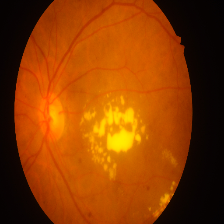

In [ ]:
#path to image over here
img_path = '/content/CF_DATA/IDRiD Testing Set/IDRiD_102.png'
cv2_imshow(cv2.resize(cv2.imread(img_path),(224,224)))

In [ ]:
#df.loc[(df['dataset'] == 'DDR') & (df['image'] == '007-4608-200')]

In [ ]:
import torchvision.models as models
model = models.efficientnet_b3(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=1536, out_features=3)

In [ ]:
#load desired model
# !pip3 install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=3)
model.load_state_dict(torch.load("/content/drive/MyDrive/optham_research/AMD-Classification/cf_models/torchcam-20.pt"))
model = model.eval()

In [ ]:
cam_extractor = SSCAM(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = resize(img, (224, 224)) / 255.0

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
for cam in cams:
  print(cam.shape)

torch.Size([112, 112])


In [ ]:
# arr = cam.numpy()*15
# for i in range(112):
#   for j in range(112):
#     if arr[i,j]>1:
#       arr[i,j]=1
#     arr[i,j]=1-arr[i,j]
# print(np.max(arr))

1.0


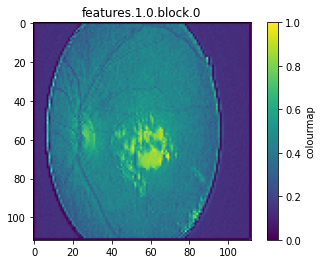

In [ ]:
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(arr); plt.axis('on'); plt.colorbar(label="colourmap", orientation="vertical"); plt.title(name); plt.show()

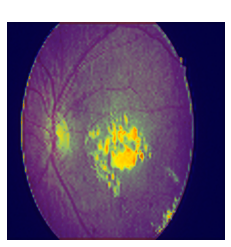

In [ ]:
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(arr, mode='F'), alpha=0.55)
  plt.imshow(result); plt.axis('off'); plt.title(' '); plt.show()

In [ ]:
cam_extractor.remove_hooks()

AttributeError: ignored

## Old stuff, after CAM

In [ ]:
accuracy_score(lbls, preds)

In [ ]:
classification_report(lbls, preds)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/optham_research/AMD-Classification/cf_models/augl1_trial_run-9.pt"))

In [ ]:
%mkdir -p /content/drive/MyDrive/optham_research/Final/classification/{valid,train}

In [ ]:
save_dict = {}
for (inputs, labels) in enumerate(tqdm(dataloaders['valid'])):
  inputs = inputs.to(device)
  with torch.no_grad():
    outputs = torch.max(model(inputs), axis=1)
  for i in range(inputs.size(0)):
    save_dict[f"/content/drive/MyDrive/optham_research/Final/classification/valid/{batch_no*BATCH_SIZE[0]+i}.png"]
    cv2.imwrite(f"/content/drive/MyDrive/optham_research/Final/classification/valid/{batch_no*BATCH_SIZE[0]+i}.png", inputs[i].detach().cpu().permute(1,2,0).numpy()*255)

In [ ]:
im, lb = next(iter(train_data))
im, lb = im.cuda(), lb.cuda()

In [ ]:
pred = model(im)

In [ ]:
cv2_imshow(im[0].permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
cv2_imshow(im[1].permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
lb

In [ ]:
torch.max(pred, axis=1)[1]